# Comparação de Modelos (Artefatos)
Este notebook não treina modelos. Ele apenas carrega os artefatos gerados para reproduzir as métricas, rankings e testes estatísticos do projeto.

- `seaborn` e `matplotlib`: Bibliotecas para visualização dos resultados.
- `scikit-posthocs`: Biblioteca para testes estatísticos pós-hoc.

In [2]:
%pip install --quiet pandas==1.5.3 numpy==1.24.4 matplotlib==3.7.5\
    seaborn==0.13.2 scikit-posthocs==0.8.0 scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.


## Configuração do ambiente


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Carregando os artefatos salvos
Agrupa todos os bundles por modelo e por dataset. Caso algum par esteja ausente,
um aviso é exibido e o dataset é ignorado nos cálculos.


In [4]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix
from artifact_utils import load_artifact_bundle
import pandas as pd
import numpy as np

MODEL_LABELS = {
    # 'saint': 'SAINT',
    'lightgbm': 'LightGBM',
    'xgboost': 'XGBoost',
    'catboost': 'CatBoost',
    # 'autogluon': 'AutoGluon',
    # 'askl2': 'ASKL 2.0'
}


def g_mean_multiclass(y_true: np.ndarray, y_pred: np.ndarray) -> float:
	"""
	Calcula a G-Mean (Média Geométrica) para problemas de classificação multiclasse.
	A G-Mean é a raiz n-ésima do produto dos recalls (sensibilidade) de cada classe.

	Por que é útil?
	-------------
	É uma métrica robusta para datasets desbalanceados. Diferente da acurácia, que pode ser 
	alta apenas acertando a classe majoritária, a G-Mean penaliza severamente o modelo 
	se ele tiver um desempenho ruim em qualquer uma das classes (recall baixo), 
	forçando o equilíbrio entre as classes.

	Args:
		y_true: Array com os rótulos verdadeiros.
		y_pred: Array com os rótulos preditos pelo modelo.

	Returns:
		float: Valor da G-Mean entre 0.0 e 1.0. Retorna 0.0 se houver erro.
	"""
	if y_pred is None:
		return np.nan

	try:
		cm = confusion_matrix(y_true, y_pred)
		row_sums = np.sum(cm, axis=1)
		mask = row_sums > 0
		recalls = np.diag(cm)[mask] / row_sums[mask]
		if len(recalls) == 0:
			return 0.0
		return np.prod(recalls) ** (1.0 / len(recalls))
	except Exception:
		return 0.0


def get_auc_ovo(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a AUC OVO (One-vs-One) para problemas multiclasse.
	
	Por que é útil?
	-------------
	A AUC OVO é uma métrica robusta para avaliar o desempenho de classificadores 
	em problemas multiclasse, especialmente quando as classes são desbalanceadas. 
	Ela considera todas as combinações possíveis de pares de classes, fornecendo 
	uma visão abrangente da capacidade do modelo em distinguir entre diferentes classes.

	Args:
		y_true: Rótulos verdadeiros.
		y_prob: Probabilidades preditas para cada classe.

	Returns:
		float: Valor da AUC OVO entre 0.0 e 1.0. Retorna np.nan se houver erro.
	"""
	if y_prob is None:
		return np.nan

	try:
		n_classes = len(np.unique(y_true))
		if n_classes == 2:
			if y_prob.ndim == 2 and y_prob.shape[1] == 2:
				return roc_auc_score(y_true, y_prob[:, 1])
			return roc_auc_score(y_true, y_prob)
		return roc_auc_score(y_true, y_prob, multi_class='ovo')
	except Exception:
		return np.nan

def get_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray) -> float:
	"""
	Calcula a entropia cruzada (log loss) para as previsões.

	A entropia cruzada mede a performance de um modelo de classificação onde a saída de previsão é um valor de probabilidade entre 0 e 1.
	A log loss aumenta à medida que a probabilidade prevista diverge do rótulo real.
	É uma métrica importante pois penaliza fortemente previsões confiantes e erradas.

	Args:
		y_true (np.ndarray): Rótulos verdadeiros.
		y_prob (np.ndarray): Probabilidades preditas.

	Returns:
		float: Valor da entropia cruzada.
	"""
	if y_prob is None:
		return np.nan

	try:
		ce = log_loss(y_true, y_prob)
	except Exception:
		ce = np.nan

	return ce


bundles_by_model = {
    key: load_artifact_bundle(key)
    for key in MODEL_LABELS
}

evaluation_rows = []
missing_models = []

for model_key, bundles in bundles_by_model.items():
	model_label = MODEL_LABELS.get(model_key, model_key.upper())
	if not bundles:
		missing_models.append(model_label)
		continue

	for bundle in bundles:
		arrays = bundle.arrays
		y_true = arrays['y_true']
		y_pred = arrays.get('y_pred')
		y_prob = arrays.get('y_prob')
		metrics_meta = bundle.metadata.get('metrics', {})
		runtime = bundle.metadata.get('runtime_seconds', np.nan)

		# 1. Acurácia
		acc = accuracy_score(y_true, y_pred) if y_pred is not None else np.nan

		# 2. G-Mean
		gmean = g_mean_multiclass(y_true, y_pred)

		# 3. AUC OVO
		auc = get_auc_ovo(y_true, y_prob)

		# 4. Cross-Entropy (Log Loss)
		ce = get_cross_entropy(y_true, y_prob)

		evaluation_rows.append({
			'Dataset': bundle.dataset_name,
			'Dataset Slug': bundle.dataset_slug,
			'Model Key': model_key,
			'Model': model_label,
			'AUC_OVO': auc,
			'Accuracy': acc,
			'G-Mean': gmean,
			'Cross_Entropy': ce,
			'Time (s)': runtime,
			'CV Score': metrics_meta.get('cv_accuracy'),
			'Test Score': metrics_meta.get('test_accuracy')
		})

if missing_models:
    print('⚠ Nenhum artefato encontrado para:')
    for model_name in missing_models:
        print(f"  - {model_name}")

results_df = pd.DataFrame()
if evaluation_rows:
    results_df = pd.DataFrame(evaluation_rows)
    results_df.to_csv('evaluation_results.csv', index=False)
    print("Resultados salvos em 'evaluation_results.csv'.")

cols = ['AUC_OVO', 'Accuracy', 'G-Mean', 'Cross_Entropy', 'Time (s)']
display(results_df.groupby('Model')[cols].mean())

Resultados salvos em 'evaluation_results.csv'.


,AUC_OVO,Accuracy,G-Mean,Cross_Entropy,Time (s)
Model,,,,,
CatBoost,0.891691,0.839776,0.693783,0.380123,219.685835
LightGBM,0.891079,0.837449,0.706506,0.397893,13.500574
XGBoost,0.888515,0.838284,0.723272,0.411032,32.084356


### heatmap de Rankings

Mostra as posições relativas dos modelos em cada dataset, por métrica. No ranking, quanto menor melhor.

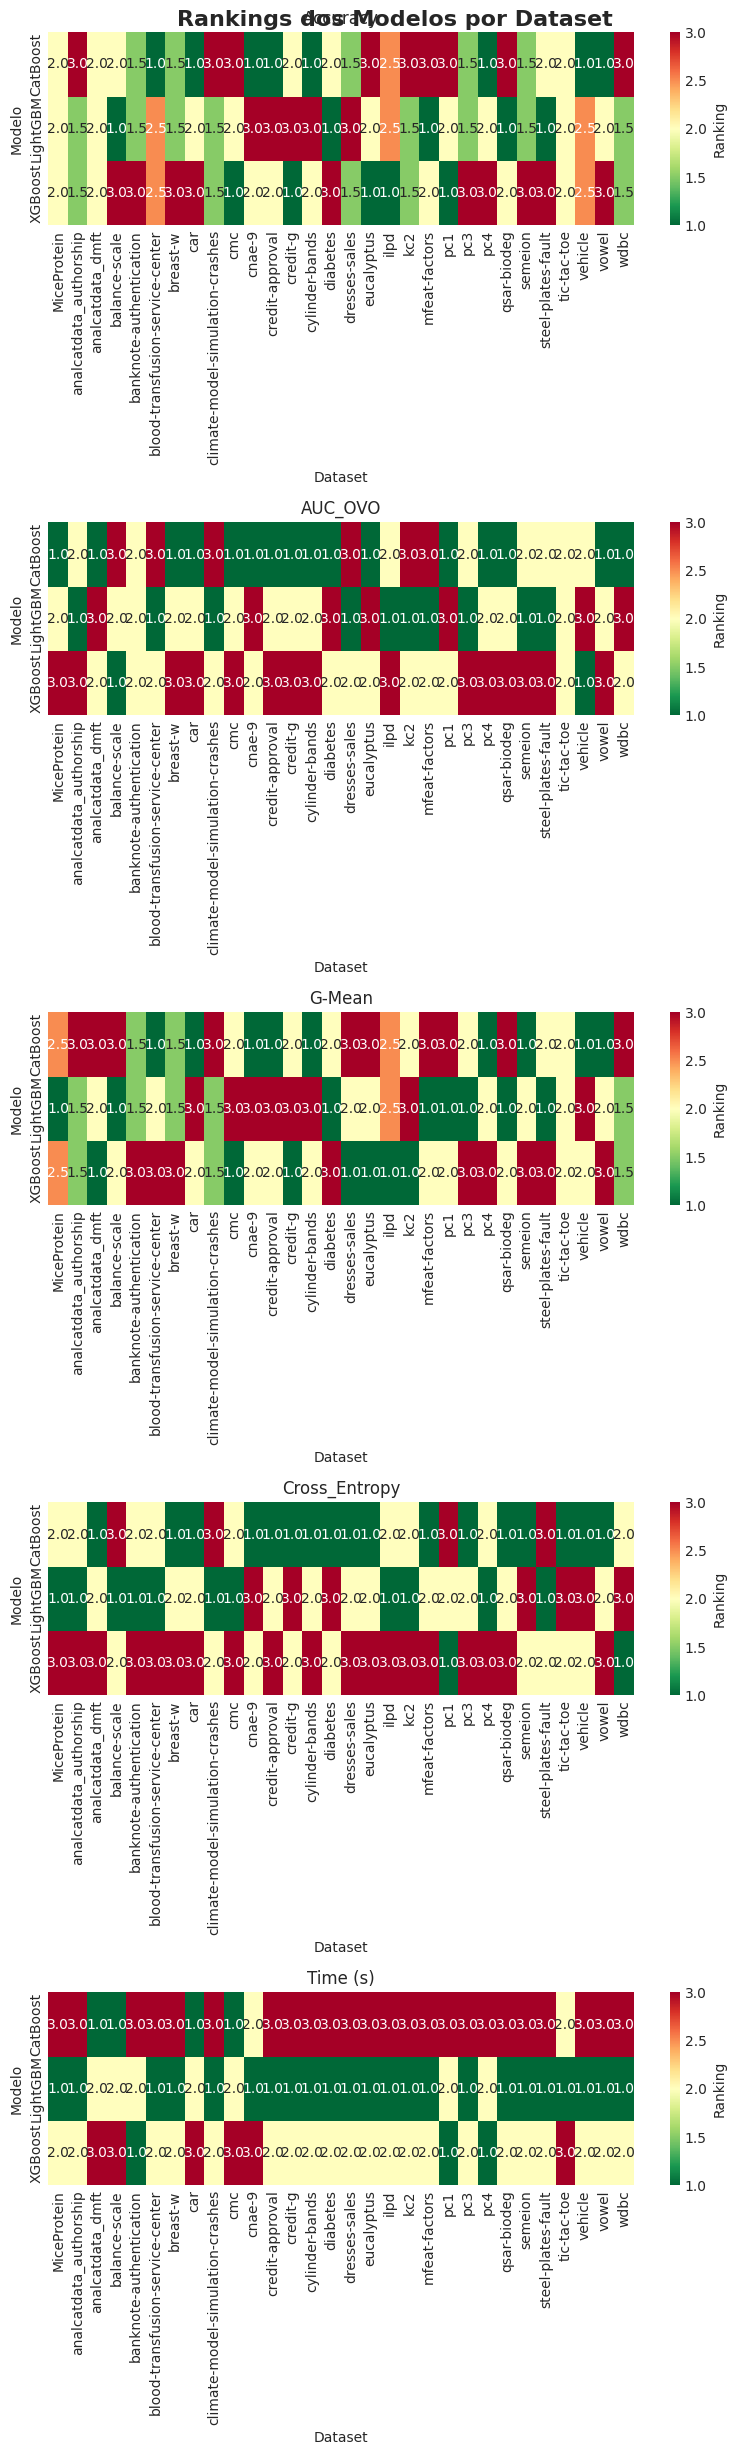

In [5]:
ranking_metrics = [
    ('Accuracy', True),
    ('AUC_OVO', True),
    ('G-Mean', True),
    ('Cross_Entropy', False),
    ('Time (s)', False)
]

fig, axes = plt.subplots(len(ranking_metrics), 1, figsize=(8, 5 * len(ranking_metrics)))
fig.suptitle('Rankings dos Modelos por Dataset', fontsize=16, fontweight='bold')

for ax, (metric, maximize) in zip(np.atleast_1d(axes), ranking_metrics):
	pivot = results_df.pivot(index='Dataset', columns='Model', values=metric).dropna()
	if pivot.empty:
		ax.set_axis_off()
		ax.set_title(f'Sem dados: {metric}')
		continue

	ranks = pivot.apply(lambda row: (-row).rank() if maximize else row.rank(), axis=1)
	sns.heatmap(
		ranks.T,
		annot=True,
		fmt='.1f',
		cmap='RdYlGn_r',
		ax=ax,
		cbar_kws={'label': 'Ranking'}
	)
	ax.set_title(metric)
	ax.set_xlabel('Dataset')
	ax.set_ylabel('Modelo')

plt.tight_layout()
plt.show()

### Painel de métricas

Mostra barras com média e desvio-padrão de cada métrica por modelo. No caso do Tempo total, quanto menor, melhor.

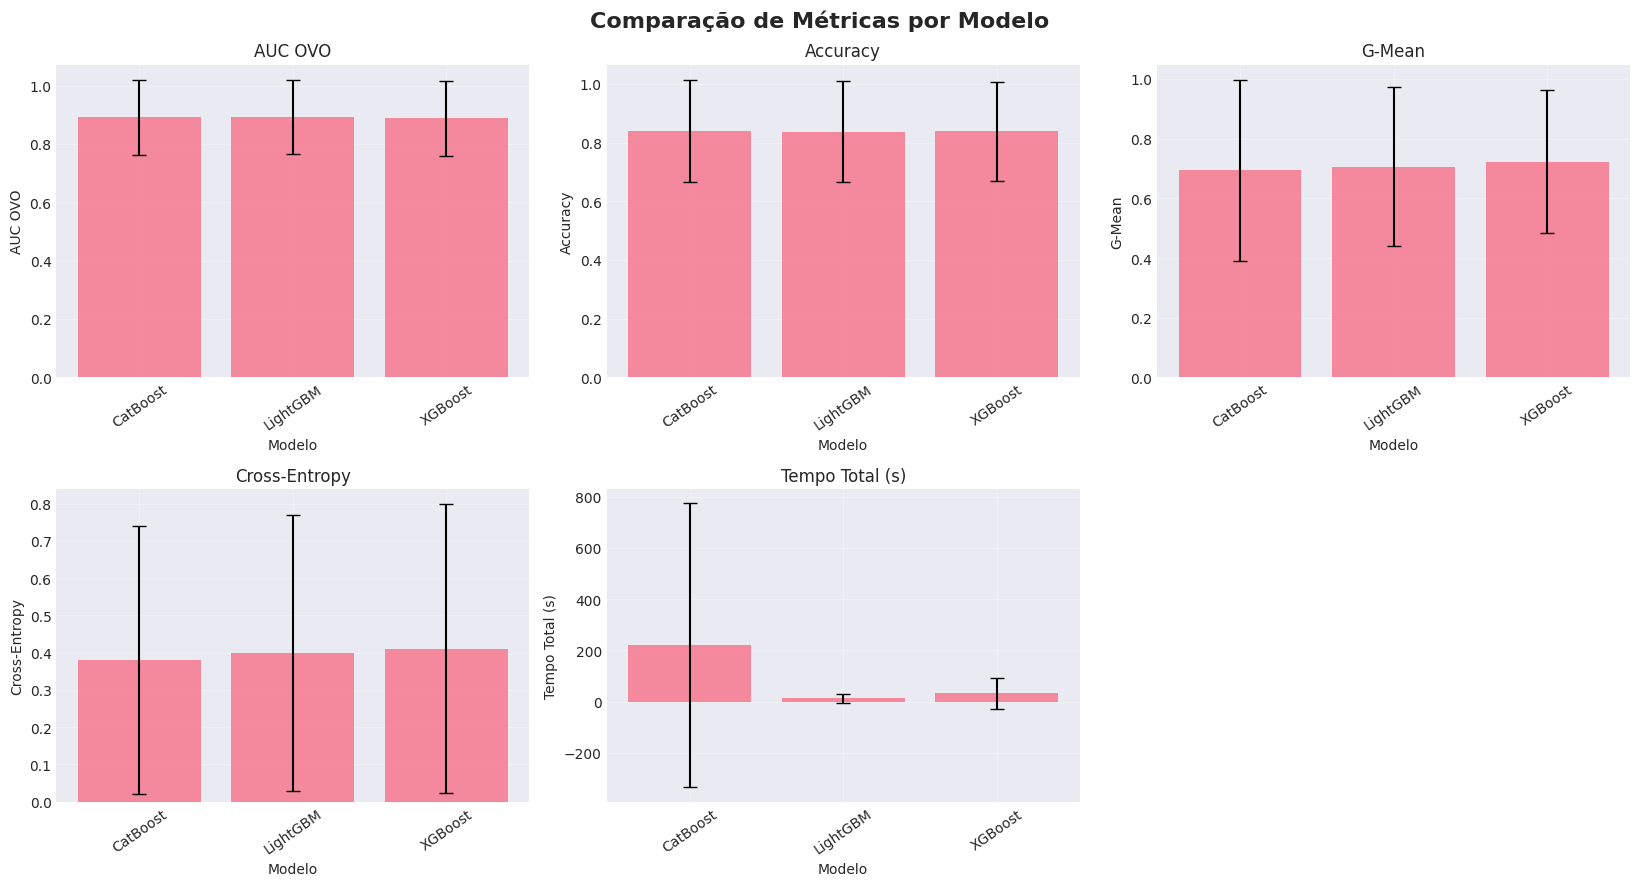

In [6]:
metric_panels = [
    ('AUC_OVO', 'AUC OVO'),
    ('Accuracy', 'Accuracy'),
    ('G-Mean', 'G-Mean'),
    ('Cross_Entropy', 'Cross-Entropy'),
    ('Time (s)', 'Tempo Total (s)')
]

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5))
fig.suptitle('Comparação de Métricas por Modelo', fontsize=16, fontweight='bold')

for idx, (metric, title) in enumerate(metric_panels):
	r, c = divmod(idx, cols)
	ax = axes[r, c]
	data = results_df.groupby('Model')[metric].agg(['mean', 'std']).reset_index()
	ax.bar(data['Model'], data['mean'], yerr=data['std'], capsize=5, alpha=0.8)
	ax.set_title(title)
	ax.set_ylabel(title)
	ax.set_xlabel('Modelo')
	ax.tick_params(axis='x', rotation=35)
	ax.grid(True, alpha=0.3)

# remover subplot vazio
if len(metric_panels) < rows * cols:
	for k in range(len(metric_panels), rows * cols):
		fig.delaxes(axes.flatten()[k])

plt.tight_layout()
plt.show()


## Análise estatística (protocolo de Demšar)

Baseado no artigo *"Statistical Comparisons of Classifiers over Multiple Data Sets"*, realizamos a comparação estatística dos modelos seguindo o protocolo recomendado para múltiplos classificadores em múltiplos datasets:

1.  **Ranking:** Calculamos o posto (rank) de cada modelo para cada dataset.
2.  **Teste de Friedman (Iman-Davenport):** Verificamos se existe diferença significativa global entre os algoritmos.
    *   Hipótese Nula ($H_0$): Todos os algoritmos têm desempenho equivalente.
3.  **Teste de Nemenyi (Post-hoc):** Se $H_0$ for rejeitada, calculamos a Diferença Crítica (CD).
    *   Dois algoritmos são significativamente diferentes se a distância entre seus ranks médios for maior que a CD.
4.  **Visualização (CD Diagram):** Plotamos os ranks médios e conectamos modelos estatisticamente equivalentes.

## Teste de Friedman

O teste de Friedman é um teste não paramétrico para detectar diferenças em tratamentos (modelos) em múltiplas tentativas (datasets).
Hipótese Nula ($H_0$): Não há diferença significativa entre o desempenho dos modelos.

## Teste de Nemenyi

Como $H_0$ foi rejeitada, realizamos o teste de Nemenyi para identificar quais pares de modelos diferem significativamente.
Este teste compara as classificações médias de todos os pares de modelos.

### Critical Difference Diagram

O diagrama mostra a classificação média de cada modelo.
Modelos conectados por uma barra horizontal grossa não são estatisticamente diferentes (p > 0.05).


--- Análise Estatística para: AUC_OVO ---

Ranks Médios (menor é melhor):
Model
CatBoost    1.666667
LightGBM    1.900000
XGBoost     2.433333
dtype: float64

Teste de Friedman: Estatística=9.9286, p-value=6.9829e-03
H0 rejeitada: Existem diferenças significativas entre os modelos.

Teste de Nemenyi (p-values) [α=0.05]:
Diferenças significativas encontradas:
  CatBoost vs XGBoost: p=8.3945e-03

Gerando Diagrama de Diferença Crítica...


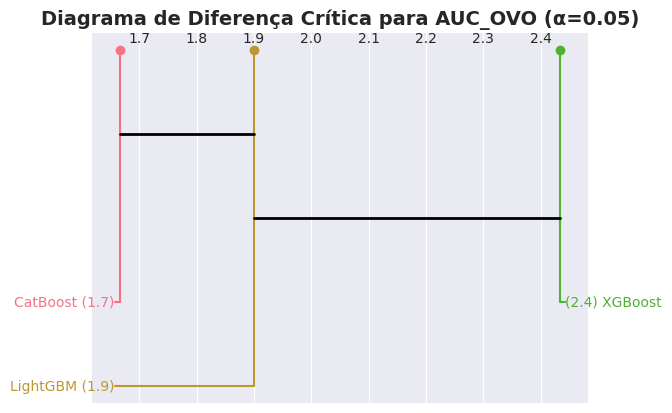


--- Análise Estatística para: Accuracy ---

Ranks Médios (menor é melhor):
Model
LightGBM    1.916667
CatBoost    1.966667
XGBoost     2.116667
dtype: float64

Teste de Friedman: Estatística=0.8125, p-value=6.6614e-01
H0 não rejeitada: Não há evidências suficientes de diferença.

--- Análise Estatística para: G-Mean ---

Ranks Médios (menor é melhor):
Model
LightGBM    1.933333
CatBoost    2.033333
XGBoost     2.033333
dtype: float64

Teste de Friedman: Estatística=0.2202, p-value=8.9575e-01
H0 não rejeitada: Não há evidências suficientes de diferença.


In [7]:
import scikit_posthocs as sp
import scipy.stats as stats

ALPHA = 0.05

for metric in ['AUC_OVO', 'Accuracy', 'G-Mean']:
	print(f"\n--- Análise Estatística para: {metric} ---")

	# Pivotar: linhas=datasets, colunas=modelos
	pivot_df = results_df.pivot(index='Dataset', columns='Model', values=metric)

	# Ranking (maior valor = melhor rank, então ascending=False para rank 1 ser o melhor)
	ranks = pivot_df.rank(axis=1, ascending=False)
	avg_ranks = ranks.mean()

	print("\nRanks Médios (menor é melhor):")
	print(avg_ranks.sort_values())

	# Teste de Friedman
	args = [pivot_df[col] for col in pivot_df.columns]
	stat, p_value = stats.friedmanchisquare(*args)

	print(f"\nTeste de Friedman: Estatística={stat:.4f}, p-value={p_value:.4e}")

	reject_h0 = p_value < ALPHA
	if reject_h0:
		print("H0 rejeitada: Existem diferenças significativas entre os modelos.")
	else:
		print("H0 não rejeitada: Não há evidências suficientes de diferença.")
		continue

	# Post-hoc Nemenyi
	if reject_h0:
		nemenyi_matrix = sp.posthoc_nemenyi_friedman(pivot_df)
		
		print(f"\nTeste de Nemenyi (p-values) [α={ALPHA}]:")
		sig_pairs = []
		cols = nemenyi_matrix.columns
		for i in range(len(cols)):
			for j in range(i+1, len(cols)):
				p = nemenyi_matrix.iloc[i, j]
				if p < ALPHA:
					sig_pairs.append((cols[i], cols[j], p))
		
		if sig_pairs:
			print("Diferenças significativas encontradas:")
			for m1, m2, p in sig_pairs:
				print(f"  {m1} vs {m2}: p={p:.4e}")
		else:
			print("Nenhuma diferença par-a-par significativa encontrada pelo Nemenyi.")

		# CD Diagram
		print("\nGerando Diagrama de Diferença Crítica...")

		fig = sp.critical_difference_diagram(avg_ranks, nemenyi_matrix)
		plt.title(f'Diagrama de Diferença Crítica para {metric} (α={ALPHA})', fontsize=14, fontweight='bold')
		plt.show()